In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import warnings

warnings.filterwarnings("ignore")
# Libraries to help with reading and manipulating data
import pandas as pd
import numpy as np

# libaries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler

In [3]:
import tensorflow as tf
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Activation,Flatten,Reshape
from keras.layers import Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
import csv
from keras.models import Model
#import keras
from keras import backend as k
from keras.layers import Input,Concatenate,Dropout,Dense,BatchNormalization,Conv1D
from keras.layers import Input
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
#from tensorflow.keras.merge import concatenate
#import tensorflow as tf
from keras.preprocessing.sequence import pad_sequences
import scipy
from keras.initializers import he_normal,glorot_normal
from keras.regularizers import l1,l2
from tensorflow.python.keras.callbacks import TensorBoard
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint,LearningRateScheduler,ReduceLROnPlateau
from time import time
from tensorflow.keras.utils import plot_model

In [4]:
train=pd.read_csv('/content/drive/MyDrive/Tweets Disaster /train.csv')
test=pd.read_csv('/content/drive/MyDrive/Tweets Disaster /test.csv')
print('Train shape:-',train.shape)
print('Test shape:-',test.shape)

Train shape:- (7613, 5)
Test shape:- (3263, 4)


In [5]:
import nltk
from tqdm import tqdm
import re
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [6]:
def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)
def decontractions(phrase):
    """decontracted takes text and convert contractions into natural form.
     ref: https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python/47091490#47091490"""
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"won\’t", "will not", phrase)
    phrase = re.sub(r"can\’t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)

    phrase = re.sub(r"n\’t", " not", phrase)
    phrase = re.sub(r"\’re", " are", phrase)
    phrase = re.sub(r"\’s", " is", phrase)
    phrase = re.sub(r"\’d", " would", phrase)
    phrase = re.sub(r"\’ll", " will", phrase)
    phrase = re.sub(r"\’t", " not", phrase)
    phrase = re.sub(r"\’ve", " have", phrase)
    phrase = re.sub(r"\’m", " am", phrase)

    return phrase

def preprocess(text_col,stopword):
    preprocessed = []
    for sentence in tqdm(text_col.values):
        # Replace "carriage return" with "space".
        sentence=str(sentence)
        sent = sentence.replace('\\r', ' ')
        # Replace "quotes" with "space".
        sent = sent.replace('\\"', ' ')
        # Replace "line feed" with "space".
        sent = sent.replace('\\n', ' ')
        # Replace characters between words with "space".
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        #remove stop words
        #decontraction
        sent=decontractions(sent)
        #Remove emoji
        sent=deEmojify(sent)
        if stopword:
            sent = ' '.join(e for e in sent.split() if e not in stopwords)
        else:
            sent = ' '.join(e for e in sent.split())
        # to lowercase
        preprocessed.append(sent.lower().strip())
    return preprocessed
train['text']=preprocess(train['text'],stopword=False)
test['text']=preprocess(test['text'],stopword=False)

100%|██████████| 3263/3263 [00:00<00:00, 24710.91it/s]


In [7]:
train['len_comm']=train['text'].apply(lambda x:len(x.split()))
test['len_comm']=test['text'].apply(lambda x:len(x.split()))

In [8]:
train['keyword']=train['keyword'].fillna('No keyword')
test['keyword']=test['keyword'].fillna('No keyword')

In [9]:
train['location']=train['location'].fillna('No location')
test['location']=test['location'].fillna('No location')

In [10]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [11]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
def generate_sentiment_scores(data):
    sid = SentimentIntensityAnalyzer()
    neg=[]
    pos=[]
    neu=[]
    comp=[]
    for sentence in tqdm(data['text'].values): 
        sentence_sentiment_score = sid.polarity_scores(sentence)
        comp.append(sentence_sentiment_score['compound'])
        neg.append(sentence_sentiment_score['neg'])
        pos.append(sentence_sentiment_score['pos'])
        neu.append(sentence_sentiment_score['neu'])
    return comp,neg,pos,neu

In [12]:
train['comp'],train['neg'],train['pos'],train['neu']=generate_sentiment_scores(train)
test['comp'],test['neg'],test['pos'],test['neu']=generate_sentiment_scores(test)

100%|██████████| 3263/3263 [00:00<00:00, 3701.58it/s]


In [13]:
y=train['target']
X=train.drop(['target','id'],axis=1)

In [14]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=42,stratify=y)

In [15]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
vec = tfidf_desc = TfidfVectorizer(max_features=200000, ngram_range=(1, 3), stop_words='english')
X_train_comment = vec.fit_transform(X_train['text'])
X_test_comment = vec.transform(X_test['text'])
test_comment=vec.transform(test['text'])

CPU times: user 642 ms, sys: 23.4 ms, total: 666 ms
Wall time: 679 ms


In [16]:
%%time
from sklearn.preprocessing import LabelBinarizer
lb_brand_keyword = LabelBinarizer(sparse_output=True)
X_train_keyword = lb_brand_keyword.fit_transform(X_train['keyword'])
X_test_keyword = lb_brand_keyword.transform(X_test['keyword'])
test_keyword = lb_brand_keyword.transform(test['keyword'])

CPU times: user 92.9 ms, sys: 16.1 ms, total: 109 ms
Wall time: 97.7 ms


In [17]:
%%time
from sklearn.preprocessing import LabelBinarizer
lb_brand_location = LabelBinarizer(sparse_output=True)
X_train_location = lb_brand_location.fit_transform(X_train['location'])
X_test_location = lb_brand_location.transform(X_test['location'])
test_location = lb_brand_location.transform(test['location'])

CPU times: user 991 ms, sys: 137 ms, total: 1.13 s
Wall time: 955 ms


In [18]:
%%time
from sklearn.preprocessing import Normalizer
trans = Normalizer()
X_train_comp=trans.fit_transform(X_train['comp'].values.reshape(-1,1))
X_test_comp=trans.transform(X_test['comp'].values.reshape(-1,1))
test_comp=trans.transform(test['comp'].values.reshape(-1,1))

CPU times: user 1.75 ms, sys: 1.07 ms, total: 2.81 ms
Wall time: 2.54 ms


In [19]:
%%time
from sklearn.preprocessing import Normalizer
trans = Normalizer()
X_train_neg=trans.fit_transform(X_train['neg'].values.reshape(-1,1))
X_test_neg=trans.transform(X_test['neg'].values.reshape(-1,1))
test_neg=trans.transform(test['neg'].values.reshape(-1,1))

CPU times: user 5.77 ms, sys: 0 ns, total: 5.77 ms
Wall time: 5.83 ms


In [20]:
%%time
from sklearn.preprocessing import Normalizer
trans = Normalizer()
X_train_pos=trans.fit_transform(X_train['pos'].values.reshape(-1,1))
X_test_pos=trans.transform(X_test['pos'].values.reshape(-1,1))
test_pos=trans.transform(test['pos'].values.reshape(-1,1))

CPU times: user 4.19 ms, sys: 0 ns, total: 4.19 ms
Wall time: 6.97 ms


In [21]:
%%time
from sklearn.preprocessing import Normalizer
trans = Normalizer()
X_train_neu=trans.fit_transform(X_train['neu'].values.reshape(-1,1))
X_test_neu=trans.transform(X_test['neu'].values.reshape(-1,1))
test_neu=trans.transform(test['neu'].values.reshape(-1,1))

CPU times: user 3.19 ms, sys: 980 µs, total: 4.17 ms
Wall time: 3.98 ms


In [22]:
%%time
from sklearn.preprocessing import Normalizer
trans = Normalizer()
X_train_len=trans.fit_transform(X_train['len_comm'].values.reshape(-1,1))
X_test_len=trans.transform(X_test['len_comm'].values.reshape(-1,1))
test_len=trans.transform(test['len_comm'].values.reshape(-1,1))

CPU times: user 6.84 ms, sys: 0 ns, total: 6.84 ms
Wall time: 6.62 ms


In [23]:
%%time
from scipy.sparse import hstack
train_s=hstack((X_train_comment,X_train_keyword,X_train_location,X_train_comp,X_train_neg,X_train_pos,X_train_neu,X_train_len)).toarray().astype('float32')
test_s=hstack((X_test_comment,X_test_keyword,X_test_location,X_test_comp,X_test_neg,X_test_pos,X_test_neu,X_test_len)).toarray().astype('float32')
test_final=hstack((test_comment,test_keyword,test_location,test_comp,test_neg,test_pos,test_neu,test_len)).toarray().astype('float32')

CPU times: user 1.89 s, sys: 3.67 s, total: 5.56 s
Wall time: 5.52 s


In [24]:
print(train_s.shape,y_train.shape)
print(test_s.shape,y_test.shape)
print(test_final.shape)

(5329, 94097) (5329,)
(2284, 94097) (2284,)
(3263, 94097)


In [26]:
from keras import regularizers
def simple_mlp_model2(input_shape):   
    model_in = Input(shape=(input_shape,), dtype='float32')
    out = Dense(4096,activation='relu',kernel_regularizer=regularizers.l2(0.001))(model_in)
    out = BatchNormalization()(out)
    out = Dropout(0.40)(out)
    out = Dense(2048,activation='relu',kernel_regularizer=regularizers.l2(0.001))(out)
    out = BatchNormalization()(out)
    out = Dropout(0.30)(out)
    out = Dense(1024, activation='relu',kernel_regularizer=regularizers.l2(0.001))(out)
    out = BatchNormalization()(out)
    out = Dropout(0.60)(out)
    out = Dense(512, activation='relu',kernel_regularizer=regularizers.l2(0.001))(out)
    out = BatchNormalization()(out)
    out = Dropout(0.30)(out)
    out = Dense(256, activation='relu',kernel_regularizer=regularizers.l2(0.001))(out)
    out = BatchNormalization()(out)
    out = Dropout(0.15)(out)
    out = Dense(128,activation='relu',kernel_regularizer=regularizers.l2(0.001))(model_in)
    out = BatchNormalization()(out)
    out = Dropout(0.10)(out)
    out = Dense(64,activation='relu',kernel_regularizer=regularizers.l2(0.001))(out)
    out = BatchNormalization()(out)
    out = Dropout(0.60)(out)
    out = Dense(32, activation='relu',kernel_regularizer=regularizers.l2(0.001))(out)
    out = BatchNormalization()(out)
    out = Dropout(0.20)(out)
    out = Dense(16, activation='relu',kernel_regularizer=regularizers.l2(0.001))(out)
    out = BatchNormalization()(out)
    out = Dropout(0.20)(out)
    out = Dense(1,activation='sigmoid')(out)
    model = Model(model_in, out)
    return model

In [27]:
model=simple_mlp_model2(train_s.shape[1])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 94097)]           0         
                                                                 
 dense_5 (Dense)             (None, 128)               12044544  
                                                                 
 batch_normalization_5 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 batch_normalization_6 (Batc  (None, 64)               256       
 hNormalization)                                             

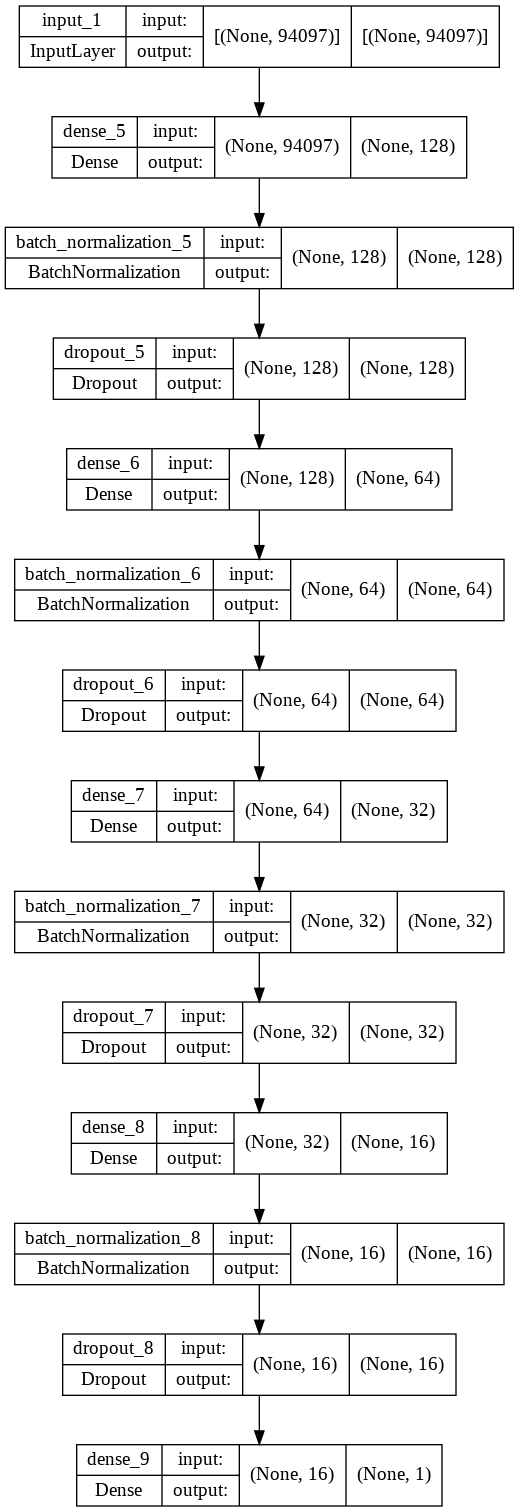

In [28]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='TB')

In [29]:
import tensorflow as tf
adam = tf.keras.optimizers.Adam(lr=0.0001)
model.compile(optimizer=adam, loss='binary_crossentropy',metrics=['accuracy'])

In [33]:
from keras.callbacks import *
import os
filepath="weights_1.best.hdf1"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, mode='max')
earlystop = EarlyStopping(monitor = 'val_accuracy',  mode="max",min_delta = 0, patience = 20,verbose = 1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.25, patience = 2, verbose = 1)
%reload_ext tensorboard
import datetime
logdir = os.path.join("logs_1", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
#tensorboard = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
tensorboard = TensorBoard(log_dir=logdir, histogram_freq=0, write_graph=True, write_grads=False, write_images=False)
callbacks = [checkpoint,reduce_lr,tensorboard,earlystop]

In [34]:
hitory1=model.fit(x=train_s,y=y_train,epochs=50,batch_size=128,validation_data=(test_s, y_test),callbacks=callbacks)

Epoch 1/50
42/42 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.7791
Epoch 1: saving model to weights_1.best.hdf1
INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets
42/42 [==============================] - 8s 193ms/step - loss: 0.6931 - accuracy: 0.7791 - val_loss: 1.0309 - val_accuracy: 0.5705 - lr: 6.2500e-06
Epoch 2/50
41/42 [============================>.] - ETA: 0s - loss: 0.6810 - accuracy: 0.7891
Epoch 2: saving model to weights_1.best.hdf1
INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets
42/42 [==============================] - 5s 132ms/step - loss: 0.6803 - accuracy: 0.7895 - val_loss: 1.0100 - val_accuracy: 0.5705 - lr: 6.2500e-06
Epoch 3/50
42/42 [==============================] - ETA: 0s - loss: 0.6790 - accuracy: 0.7945
Epoch 3: saving model to weights_1.best.hdf1
INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets

Epoch 3: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.
42/42 [==================

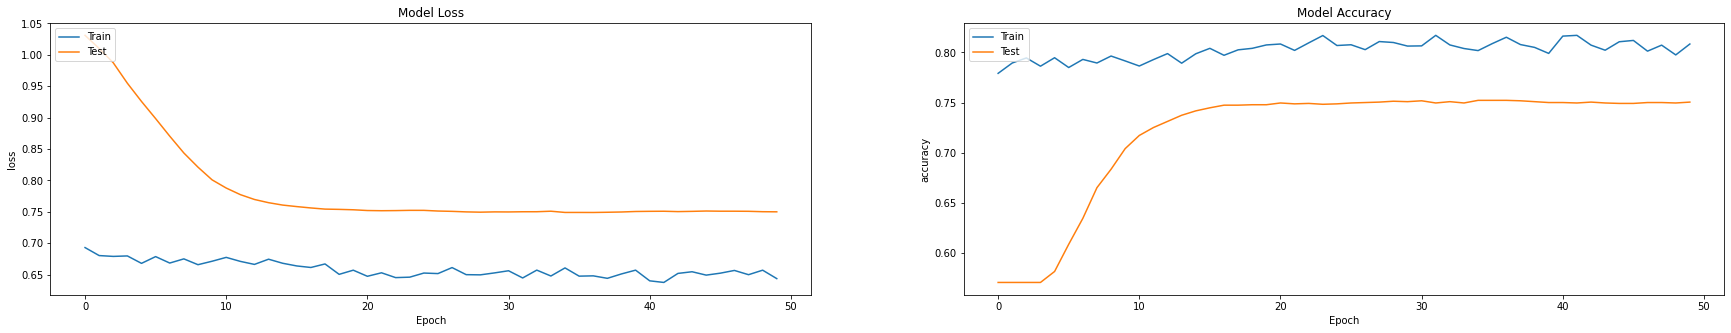

In [35]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(hitory1.history['loss'])
plt.plot(hitory1.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation f1_score
plt.subplot(122)
plt.plot(hitory1.history['accuracy'])
plt.plot(hitory1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [25]:
from keras import regularizers
def simple_mlp_model1(input_shape):   
    model_in = Input(shape=(input_shape,), dtype='float32')
    out = Dense(128,activation='relu',kernel_regularizer=regularizers.l2(0.001))(model_in)
    out = Dense(64,activation='relu',kernel_regularizer=regularizers.l2(0.001))(out)
    out = Dropout(0.2)(out)
    out = Dense(1,activation='sigmoid')(out)
    model = Model(model_in, out)
    return model

In [26]:
model=simple_mlp_model1(train_s.shape[1])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 94097)]           0         
                                                                 
 dense (Dense)               (None, 128)               12044544  
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 12,052,865
Trainable params: 12,052,865
Non-trainable params: 0
_________________________________________________________________


In [27]:
adam = tf.keras.optimizers.Adam(lr=0.0001)
model.compile(
    loss =  'binary_crossentropy',
    optimizer = adam,
    metrics = ['accuracy']
)

In [28]:
from keras.callbacks import *
import os
earlystop = EarlyStopping(monitor = 'val_accuracy',  mode="max",min_delta = 0, patience = 20,verbose = 1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.25, patience = 2, verbose = 1)

callbacks = [reduce_lr,earlystop]

In [29]:
hitory=model.fit(x=train_s,y=y_train,epochs=50,batch_size=128,validation_data=(test_s, y_test),callbacks=callbacks)

Epoch 1/50
42/42 [==============================] - 5s 60ms/step - loss: 0.9104 - accuracy: 0.5917 - val_loss: 0.8191 - val_accuracy: 0.6143 - lr: 1.0000e-04
Epoch 2/50
42/42 [==============================] - 2s 57ms/step - loss: 0.7798 - accuracy: 0.6742 - val_loss: 0.7493 - val_accuracy: 0.7369 - lr: 1.0000e-04
Epoch 3/50
42/42 [==============================] - 3s 67ms/step - loss: 0.7227 - accuracy: 0.7621 - val_loss: 0.7085 - val_accuracy: 0.7636 - lr: 1.0000e-04
Epoch 4/50
42/42 [==============================] - 3s 61ms/step - loss: 0.6735 - accuracy: 0.8236 - val_loss: 0.6745 - val_accuracy: 0.7815 - lr: 1.0000e-04
Epoch 5/50
42/42 [==============================] - 2s 46ms/step - loss: 0.6220 - accuracy: 0.8619 - val_loss: 0.6457 - val_accuracy: 0.7916 - lr: 1.0000e-04
Epoch 6/50
42/42 [==============================] - 2s 47ms/step - loss: 0.5711 - accuracy: 0.8825 - val_loss: 0.6232 - val_accuracy: 0.7990 - lr: 1.0000e-04
Epoch 7/50
42/42 [==============================] - 

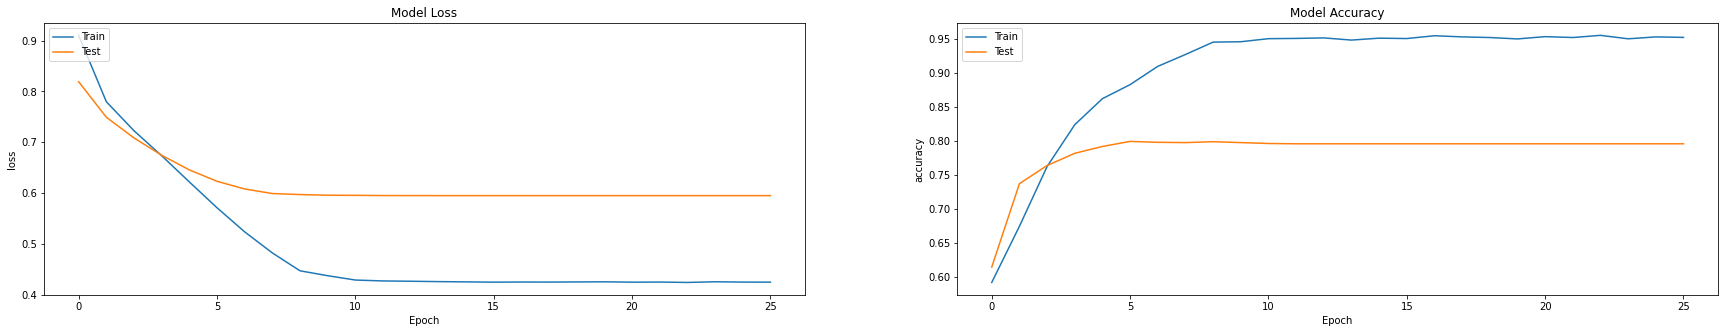

In [30]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(hitory.history['loss'])
plt.plot(hitory.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation f1_score
plt.subplot(122)
plt.plot(hitory.history['accuracy'])
plt.plot(hitory.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [37]:
def cal(y_pred):
  val=[]
  for value in y_pred:
    if value>=0.5:
      val.append(1)
    else:
      val.append(0)
  return val
y_pred=model.predict(test_final)
y_pred=cal(y_pred)

In [38]:
submission=pd.read_csv('/content/drive/MyDrive/Tweets Disaster /sample_submission.csv')
submission.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [40]:
submission['target']=y_pred
submission.to_csv('final_submissionn_2.csv',index=False)

In [25]:
from keras import regularizers
def simple_mlp_model3(input_shape):   
    model_in = Input(shape=(input_shape,), dtype='float32')
    out = Dense(64,activation='relu',kernel_regularizer=regularizers.l2(0.001))(model_in)
    out=Dropout(0.1)(out)
    out = Dense(16,activation='relu',kernel_regularizer=regularizers.l2(0.001))(out)
    out = Dropout(0.2)(out)
    out = Dense(1,activation='sigmoid')(out)
    model = Model(model_in, out)
    return model

In [26]:
model=simple_mlp_model3(train_s.shape[1])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 94097)]           0         
                                                                 
 dense (Dense)               (None, 64)                6022272   
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                1040      
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 6,023,329
Trainable params: 6,023,329
Non-train

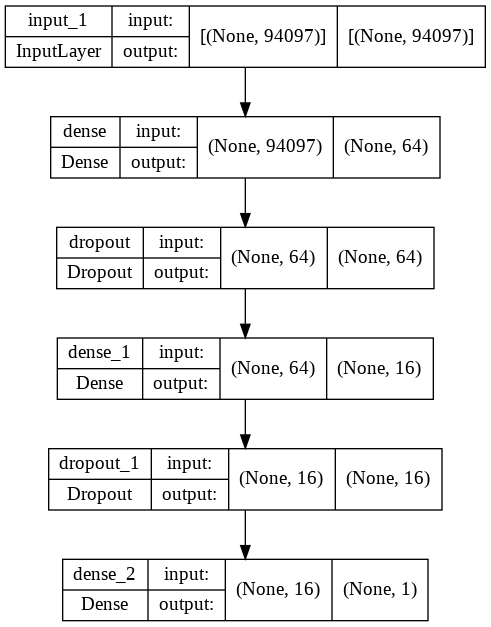

In [27]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='TB')

In [28]:
adam = tf.keras.optimizers.Adam(lr=0.0001)
model.compile(
    loss =  'binary_crossentropy',
    optimizer = adam,
    metrics = ['accuracy']
)

In [29]:
from keras.callbacks import *
import os
earlystop = EarlyStopping(monitor = 'val_accuracy',  mode="max",min_delta = 0, patience = 20,verbose = 1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.25, patience = 2, verbose = 1)

callbacks = [reduce_lr,earlystop]

In [30]:
hitory=model.fit(x=train_s,y=y_train,epochs=50,batch_size=128,validation_data=(test_s, y_test),callbacks=callbacks)

Epoch 1/50
42/42 [==============================] - 13s 103ms/step - loss: 0.7856 - accuracy: 0.5746 - val_loss: 0.7401 - val_accuracy: 0.5998 - lr: 1.0000e-04
Epoch 2/50
42/42 [==============================] - 2s 42ms/step - loss: 0.7199 - accuracy: 0.6296 - val_loss: 0.7038 - val_accuracy: 0.6764 - lr: 1.0000e-04
Epoch 3/50
42/42 [==============================] - 2s 41ms/step - loss: 0.6888 - accuracy: 0.7011 - val_loss: 0.6819 - val_accuracy: 0.7106 - lr: 1.0000e-04
Epoch 4/50
42/42 [==============================] - 2s 40ms/step - loss: 0.6637 - accuracy: 0.7495 - val_loss: 0.6650 - val_accuracy: 0.7294 - lr: 1.0000e-04
Epoch 5/50
42/42 [==============================] - 2s 42ms/step - loss: 0.6417 - accuracy: 0.7814 - val_loss: 0.6504 - val_accuracy: 0.7588 - lr: 1.0000e-04
Epoch 6/50
42/42 [==============================] - 2s 42ms/step - loss: 0.6202 - accuracy: 0.8082 - val_loss: 0.6377 - val_accuracy: 0.7701 - lr: 1.0000e-04
Epoch 7/50
42/42 [==============================] 

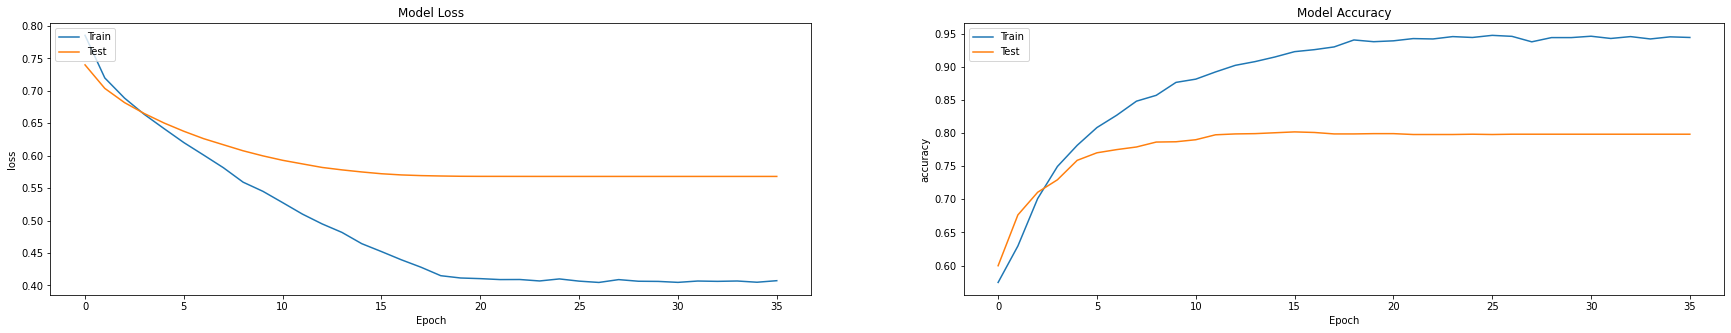

In [31]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(hitory.history['loss'])
plt.plot(hitory.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation f1_score
plt.subplot(122)
plt.plot(hitory.history['accuracy'])
plt.plot(hitory.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [32]:
def cal(y_pred):
  val=[]
  for value in y_pred:
    if value>=0.5:
      val.append(1)
    else:
      val.append(0)
  return val
y_pred=model.predict(test_final)
y_pred=cal(y_pred)

In [33]:
submission=pd.read_csv('/content/drive/MyDrive/Tweets Disaster /sample_submission.csv')
submission['target']=y_pred
submission.to_csv('final_submissionn_3.csv',index=False)